# Principal Component Analysis & Featue Importance

## PCA

In [1]:
import pandas as pd
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# https://www.kaggle.com/datasets/saurabh00007/iriscsv
filename = 'Iris.csv'
df = pd.read_csv(filename, index_col=0)
cols_x = list(df.columns[0:4])
col_y = df.columns[4]

# model pipeline for PCA
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
])
features = df[cols_x]
pipe.fit(features)

# PCA scores
scores = pipe.transform(features)
df_pca = pd.DataFrame(
    scores,
    columns=["PC{}".format(x + 1) for x in range(scores.shape[1])],
    index=df.index
)
cols_pc = list(df_pca.columns)
df_pca.insert(0, col_y, df[col_y].copy())
dfi.export(df_pca.head(), 'table_061_iris_PCA.png')
df_pca.head()

/usr/bin/google-chrome


,Species,PC1,PC2,PC3,PC4
Id,,,,,
1,Iris-setosa,-2.264542,0.505704,-0.121943,-0.023073
2,Iris-setosa,-2.086426,-0.655405,-0.227251,-0.103208
3,Iris-setosa,-2.367950,-0.318477,0.051480,-0.027825
4,Iris-setosa,-2.304197,-0.575368,0.098860,0.066311
5,Iris-setosa,-2.388777,0.674767,0.021428,0.037397


## Scatter for PCs

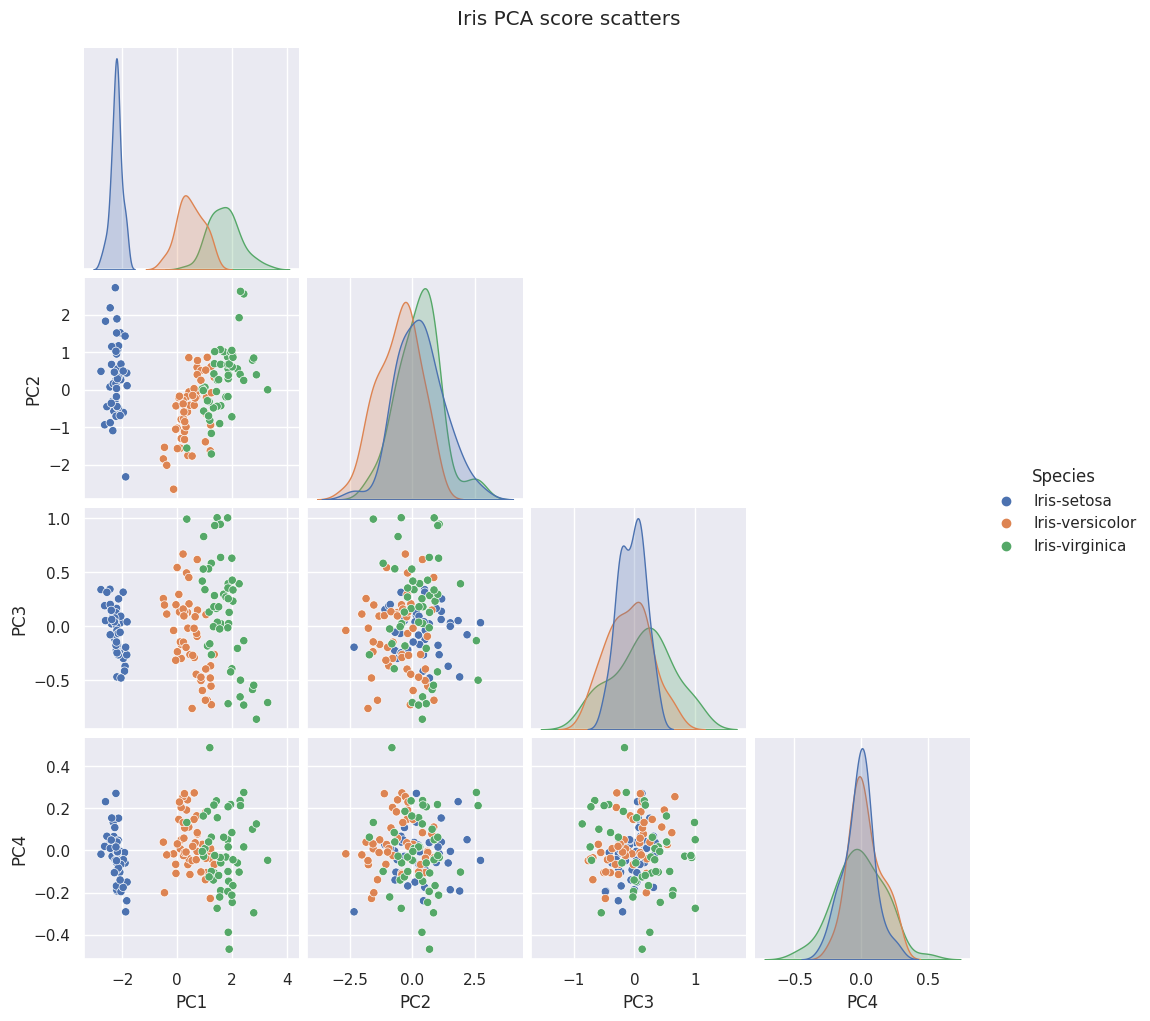

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 14
sns.set()

g = sns.pairplot(df_pca, hue=col_y, corner=True)
g.fig.suptitle('Iris PCA score scatters', y=1.02)

plt.savefig('iris_061_PCA_scatter.png')
plt.show()

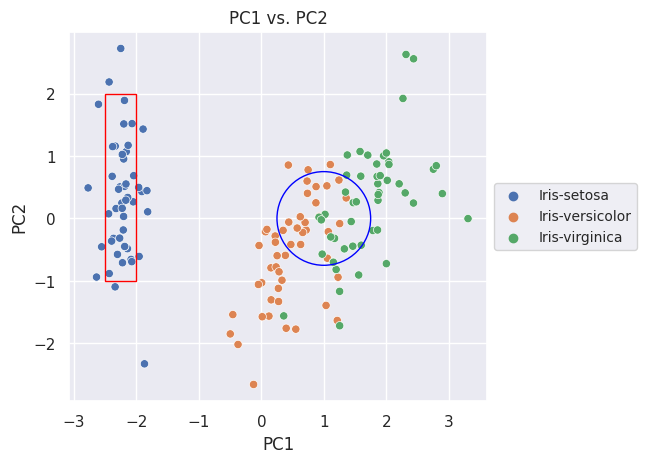

In [16]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=col_y, ax=ax)
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_title('PC1 vs. PC2')


x1 = -2.5
y1 = -1.0
w1 = 0.5
h1 = 3.0
c1 = patches.Rectangle(xy=(x1, y1) , width=w1, height=h1, fill=False, edgecolor='red')
ax.add_patch(c1)

x2 = 1.0
y2 = 0.0
r2 = 0.75
c2 = patches.Circle(xy=(x2, y2), radius=r2, fill=False, edgecolor='blue')
ax.add_patch(c2)

plt.savefig('iris_062_PCA_PC1PC2.png')
plt.show()

In [24]:
df_cluster_1 = df[(df_pca['PC1'] > x1) & (df_pca['PC1'] < (x1 + w1)) & (df_pca['PC2'] > y1) & (df_pca['PC2'] < (y1 + h1))].copy()
df_cluster_1['Cluster'] = 1

In [25]:
df_cluster_2 = df[((df_pca['PC1'] - x2)**2 < r2**2) & ((df_pca['PC2'] - y2)**2 < r2**2)].copy()
df_cluster_2['Cluster'] = 2

In [28]:
df_cluster = pd.concat([df_cluster_1, df_cluster_2])
df_cluster

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Cluster
Id,,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa,1
2,4.9,3.0,1.4,0.2,Iris-setosa,1
3,4.7,3.2,1.3,0.2,Iris-setosa,1
4,4.6,3.1,1.5,0.2,Iris-setosa,1
5,5.0,3.6,1.4,0.2,Iris-setosa,1
...,...,...,...,...,...,...
138,6.4,3.1,5.5,1.8,Iris-virginica,2
139,6.0,3.0,4.8,1.8,Iris-virginica,2
143,5.8,2.7,5.1,1.9,Iris-virginica,2
